# Simulador sistema de riego

En esta práctica simularemos el sistema de riego de cesped de un campo de fútbol. Nuestro sistema de riego está formado por un sensor de temperatura y un sensor de humedad en el terreno.

Dependiendo de los valores de estos sensores, el sistema de riego decidirá si activar o no el aspersor y con que intensidad. El objetivo es mantener la humedad del terreno de juego entre el 20% y el 25%.

## Variables físicas del sistema

Primero, definiremos el funcionamiento de las variables físicas del sistema. Para simplificar el problema, consideraremos que la temperatura se definirá por una función sinusoidal.

La función de python que define la temperatura es la siguiente:

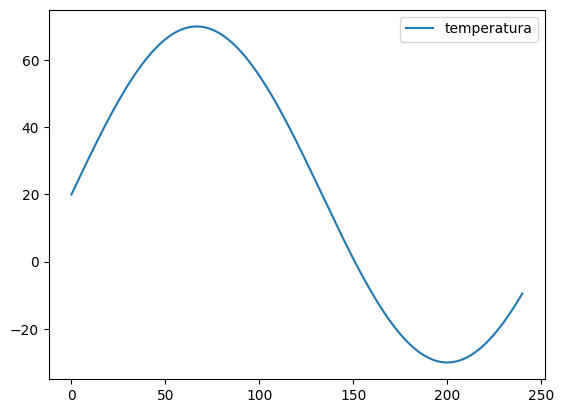

In [1]:
import numpy as np

def calc_temperatura(t):
    return 20 + 50 * np.sin(1.5 * np.pi * t / 200)

# Grafiquem la funció

import matplotlib.pyplot as plt

t = np.arange(0, 240, 0.1)
plt.plot(t, calc_temperatura(t), label='temperatura')
plt.legend()
plt.show()

La humedad del terreno comenzará en un 20% y aumentará o disminuirá dependiendo de la temperatura y si se activa o no el aspersor. La función de python que define la humedad del terreno es la siguiente:

In [2]:
def humitat_terreny(h_actual=20, temperatura=20, aspersor=0):
    h = h_actual + 0.1 * (aspersor - 50) + 0.1 * (temperatura - 20) / 30
    return h

## Definición de sistema de riego simple

En esta sección, definiremos un controlador simple para el sistema riego. Este controlador activará el aspersor cuando la humedad en el terreno sea inferior al 20% y desactivará el aspersor cuando la humedad en el terreno sea más del 25%. De lo contrario, el controlador mantendrá el aspersor con una intensidad proporcional a la humedad del terreno.

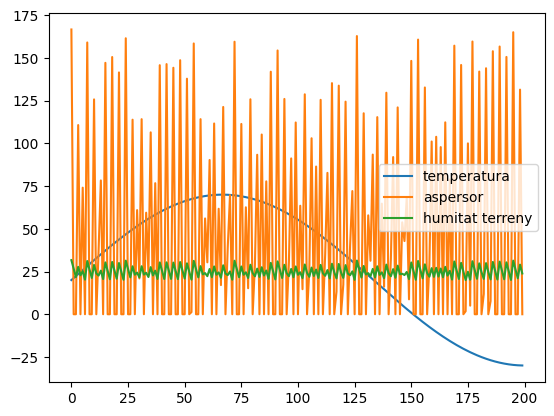

In [3]:
def controlador_simple(humitat_terreny_actual,  temperatura=20):
    if humitat_terreny_actual < 20:
        return 100
    elif humitat_terreny_actual > 25:
        return 0
    else:
        return (25 - humitat_terreny_actual) * 100 / 3

def simula_regat(cnt, humitat_terreny_actual=20, t_final=100):
    # Definim els vectors de temps i de valors de les variables
    temperatures = []
    humitats_terreny = []
    aspersors = []
    for i in range(t_final):
        temp = calc_temperatura(i)
        temperatures.append(temp)

        aspersor = cnt(humitat_terreny_actual, temp)
        aspersors.append(aspersor)

        humitat_terreny_actual = humitat_terreny(h_actual=humitat_terreny_actual, temperatura=temp, aspersor=aspersor)
        humitats_terreny.append(humitat_terreny_actual)

    # Grafiquem els resultats
    plt.plot(temperatures, label='temperatura')
    plt.plot(aspersors, label='aspersor')
    plt.plot(humitats_terreny, label='humitat terreny')
    plt.legend()

simula_regat(controlador_simple, 20, 200)

## Controlador difuso

En esta sección, definiremos un controlador difuso para el sistema de regado.

Para la implementación del controlador, utilizaremos la librería [Scikit-Fuzzy] (https://pythonhosted.org/scikit-fuzzy/). Esta librería nos permitirá definir las funciones de pertenencia y las reglas difusas de una manera simple.

Comenzaremos importando las librerías necesarias:

In [4]:
%pip install scikit-fuzzy==0.4.2 #La libreria 0.5 es más reciente pero tiene problemas con el ControlSystem.view()
# Importamos las librerías necesarias

import skfuzzy as fuzz
from skfuzzy import control as ctrl

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 994.0/994.0 kB 12.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for scikit-fuzzy: filename=scikit_fuzzy-0.4.2-py3-none-any.whl size=894076 sha256=0af17519567cded194befc6baa05e9432df1aeb5636be5dd0f70fd34704db437
  Stored in directory: /root/.cache/pip/wheels/4f/86/1b/dfd97134a2c8313e519bcebd95d3fedc7be7944db022094bc8
Successfully built scikit-fuzzy


## Definición de antecedentes y consecuentes

Primero, definiremos los antecedentes y los consecuentes del sistema de riego. Los antecedentes son los sensores de temperatura y humedad del terreno. Los consecuentes son los valores del Aspersor.

In [5]:
# Definimos los antecedentes y el consecuente

# Fondo

# Temperatura
temperatura = ctrl.Antecedent(np.arange(-10, 101, 1), 'temperatura (ºC)')

# Humedad del suelo
humitat = ctrl.Antecedent(np.arange(0, 101, 1), 'humitat terreny (%)')

# Consecuentes

# Aspersor
aspersor = ctrl.Consequent(np.arange(0, 101, 1), 'aspersor (%)')

## Definición de funciones de pertenencia

A continuación, definiremos las funciones de pertenencia de los antecedentes y de los consecuentes. Para cada antecedente y para cada consecuente, definiremos las funciones de pertenencia que consideramos necesarias. En este caso, definiremos las funciones de pertenencia triangular.

Para definir las funciones de pertenencia, utilizaremos la función `trimf` de la librería `Skfuzzy`. Esta función recibe como parámetro un vector con los puntos de la función de pertenencia.

Para definir los puntos de las funciones de pertenencia,nos basaremos en los criterios de la siguiente tabla:

| Antecedente | Puntos de la función de pertenencia |
| ----------- | ----------------------------------- |
| Humedad | Seco: 0, 0, 17 <br> Apropiado: 15, 20, 25 <br> Húmedo: 23, 50, 100 |
| Temperatura | Frío: -10, 0, 15 <br> Normal: 12, 20, 28 <br> Calor: 24, 31.5, 39 <br> Muy calor: 35, 65.5, 100 |
| Aspersor | Muy poco: -20, 0, 20 <br> Poco: 15, 30, 45 <br> Medio: 40, 55, 70 <br> Mucho: 65, 75, 85 <br> Máximo: 80, 100, 120 |



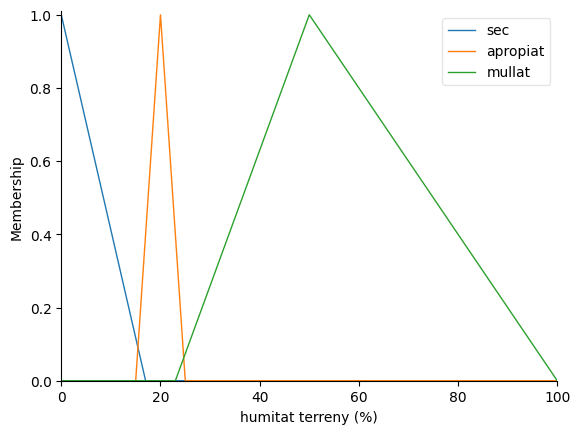

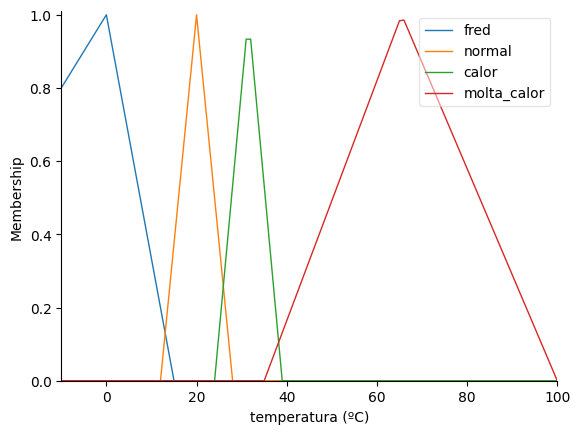

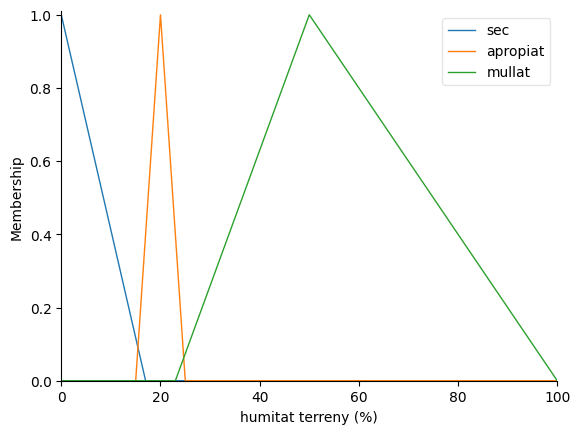

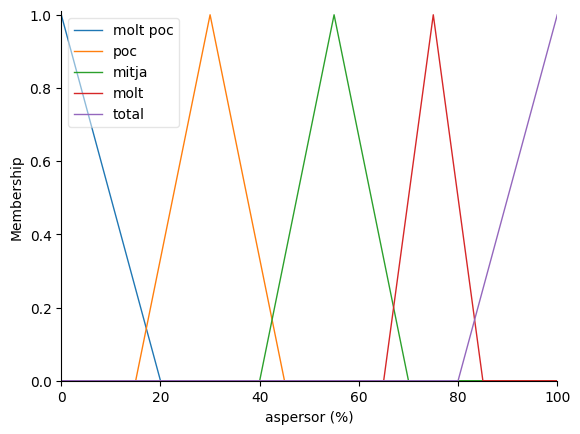

In [6]:
# Definimos las funciones de adherencia de los antecedentes y el consecuente

# Terreno de humedad
humitat['sec'] = fuzz.trimf(humitat.universe, [0, 0, 17])
humitat['apropiat'] = fuzz.trimf(humitat.universe, [15, 20, 25])
humitat['mullat'] = fuzz.trimf(humitat.universe, [23, 50, 100])

# Temperatura
temperatura['fred'] = fuzz.trimf(temperatura.universe, [-50, 0, 15])
temperatura['normal'] = fuzz.trimf(temperatura.universe, [12, 20, 28])
temperatura['calor'] = fuzz.trimf(temperatura.universe, [24, 31.5, 39])
temperatura['molta_calor'] = fuzz.trimf(temperatura.universe, [35, 65.5, 100])

# Aspersor
aspersor['molt poc'] = fuzz.trimf(aspersor.universe, [-20, 0, 20])
aspersor['poc'] = fuzz.trimf(aspersor.universe, [15, 30, 45])
aspersor['mitja'] = fuzz.trimf(aspersor.universe, [40, 55, 70])
aspersor['molt'] = fuzz.trimf(aspersor.universe, [65, 75, 85])
aspersor['total'] = fuzz.trimf(aspersor.universe, [80, 100, 120])

# Vemos las funciones de pertenencia
humitat.view()
temperatura.view()
humitat.view()

aspersor.view()

## Definición de reglas difusas

Ahora definimos las reglas difusas del sistema de riego. Para definir las reglas difusas, utilizaremos la librería `Ctrl.Rule` de la librería `skfuzzy`. Esta función recibe los antecedentes y los consecuentes de la regla difusa, así como el operador lógico que se aplicará entre los antecedentes.

En nuestro caso, definiremos las siguientes reglas difusas:

| Humedad | Temperatura | Aspersor |
| ----------- | ----------- | ----------- |
|Seco |Frío |Mucho |
|Seco |Normal |Mucho |
|Seco |Caliente |Total |
|Seco |Muy caliente |Total |
|Apropiado |Frío |Poco |
|Apropiado |Normal |Poco |
|Apropiado |Caliente |Medio |
|Apropiado |Muy caliente |Medio |
|Húmedo |Frío |Muy poco |
|Húmedo |Normal |Muy poco |
|Húmedo |Caliente |Muy poco |
|Húmedo |Muy caliente |Poco |

  

In [7]:
# Definimos las reglas difusas

regla1 = ctrl.Rule(humitat['sec'] & temperatura['fred'], aspersor['mitja'])
regla2 = ctrl.Rule(humitat['sec'] & temperatura['normal'], aspersor['mitja'])
regla3 = ctrl.Rule(humitat['sec'] & temperatura['calor'], aspersor['mitja'])
regla4 = ctrl.Rule(humitat['sec'] & temperatura['molta_calor'], aspersor['mitja'])
regla5 = ctrl.Rule(humitat['apropiat'] & temperatura['fred'], aspersor['poc'])
regla6 = ctrl.Rule(humitat['apropiat'] & temperatura['normal'], aspersor['poc'])
regla7 = ctrl.Rule(humitat['apropiat'] & temperatura['calor'], aspersor['mitja'])
regla8 = ctrl.Rule(humitat['apropiat'] & temperatura['molta_calor'], aspersor['mitja'])
regla9 = ctrl.Rule(humitat['mullat'] & temperatura['fred'], aspersor['molt poc'])
regla10 = ctrl.Rule(humitat['mullat'] & temperatura['normal'], aspersor['molt poc'])
regla11 = ctrl.Rule(humitat['mullat'] & temperatura['calor'], aspersor['molt poc'])
regla12 = ctrl.Rule(humitat['mullat'] & temperatura['molta_calor'], aspersor['poc'])

## Definición del sistema de riego
Luego definimos el sistema de riego. Para definir el sistema de riego, utilizaremos la función `ctrl.controlsystem` de la librería `skfuzzy`. Esta función recibe como parámetro una lista con las reglas difusas del sistema.

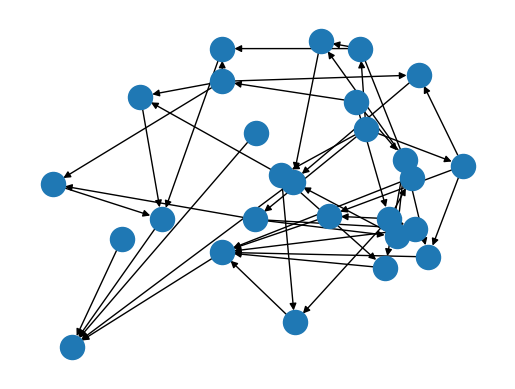

In [8]:
# Definimos el sistema de riego

sistema_regat = ctrl.ControlSystem([regla1, regla2, regla3, regla4, regla5, regla6, regla7, regla8, regla9, regla10, regla11, regla12])

# Vemos el sistema de riego
sistema_regat.view()

## Definición de simulador de sistema de riego

Luego definimos el simulador del sistema de riego. Para definir el simulador del sistema de riego, utilizaremos la función `ctrl.controlsystemsimulation` de la librería `skfuzzy`. Esta función recibe el sistema de riego como un parámetro.

In [9]:
# Definimos el simulador del sistema de riego

simulador_regat = ctrl.ControlSystemSimulation(sistema_regat)

## Simulación del sistema de riego

Ahora simulamos el sistema de riego.

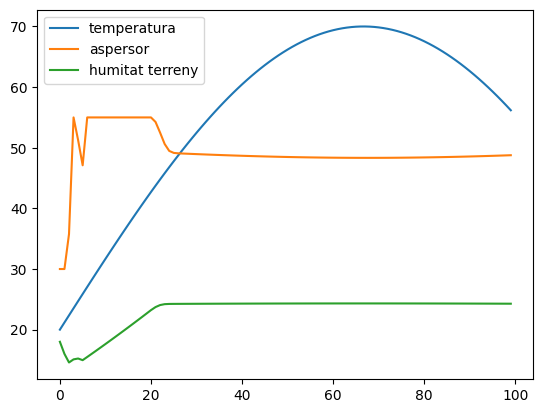

In [10]:
def controlador_difus(humitat_terreny_actual, temperatura):
    # Definimos los antecedentes del sistema de riego
    simulador_regat.input['humitat terreny (%)'] = humitat_terreny_actual
    simulador_regat.input['temperatura (ºC)'] = temperatura

    # Ejecutamos el sistema de riego
    try:
        simulador_regat.compute()
    except Exception as e:
        print("Humi. terreny: " + str(humitat_terreny_actual) + " Temp.: " + str(temperatura))

    # Devuelve el valor del ascersor
    return simulador_regat.output['aspersor (%)']

simula_regat(controlador_difus, 20, 100)